# Keyword Spotting Model Training
## Based on MF2143 Tutorial 2 - Local Training Workflow

This notebook replicates the Colab training workflow locally for training a keyword spotting model on the Speech Commands dataset.

**Requirements:**
- **Python 3.9 REQUIRED** - This has been tested and verified to work with Python 3.9 only
- GPU with CUDA support recommended for faster training

In [1]:
# Check Python version
import sys
print(f"Python version: {sys.version}")

# Verify Python 3.9
assert sys.version_info.major == 3 and sys.version_info.minor == 9, \
    "ERROR: Python 3.9 is required! Current version: {}.{}".format(
        sys.version_info.major, sys.version_info.minor
    )

print("✓ Python 3.9 detected")

# Install required packages
# Uncomment the line below if you need to install dependencies
# !pip install -r requirements.txt

Python version: 3.9.25 (main, Nov  3 2025, 22:33:05) 
[GCC 11.2.0]
✓ Python 3.9 detected


## Step 1: Download and Load the Speech Commands Dataset

In [4]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import shutil
import tarfile
import urllib.request

# Set dataset directory
DATASET_DIR = pathlib.Path(os.getcwd()) / 'datasets'
DATASET_DIR.mkdir(exist_ok=True)

# Target keywords
TARGET_WORDS = ['left', 'right', 'go']

print(f"Dataset directory: {DATASET_DIR}")
print(f"Target keywords: {TARGET_WORDS}")

# Download Speech Commands dataset v0.02
SPEECH_COMMANDS_PATH = DATASET_DIR / 'speech_commands_v0.02'
ARCHIVE_PATH = DATASET_DIR / 'speech_commands_v0.02.tar.gz'

if not SPEECH_COMMANDS_PATH.exists():
    print("\nDownloading Speech Commands dataset v0.02 (~2.4 GB)...")
    url = 'https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz'
    
    # Download with progress
    def download_progress(block_num, block_size, total_size):
        downloaded = block_num * block_size
        percent = min(downloaded / total_size * 100, 100)
        print(f"\rDownload progress: {percent:.1f}% ({downloaded / (1024**2):.1f} / {total_size / (1024**2):.1f} MB)", end='')
    
    urllib.request.urlretrieve(url, ARCHIVE_PATH, download_progress)
    print("\nDownload complete!")
    
    # Extract archive
    print("Extracting archive...")
    SPEECH_COMMANDS_PATH.mkdir(exist_ok=True)
    with tarfile.open(ARCHIVE_PATH, 'r:gz') as tar:
        tar.extractall(SPEECH_COMMANDS_PATH)
    print("Extraction complete!")
    
    # Remove archive to save space
    ARCHIVE_PATH.unlink()
    print("Removed archive file")
else:
    print("Dataset already downloaded")

# Filter: Keep only target words and background noise
print("\nFiltering dataset...")
all_folders = [f for f in SPEECH_COMMANDS_PATH.iterdir() if f.is_dir()]
print(f"Total folders found: {len(all_folders)}")

removed_count = 0
for folder in all_folders:
    folder_name = folder.name
    # Keep target words and background noise
    if folder_name not in TARGET_WORDS and folder_name != '_background_noise_':
        shutil.rmtree(folder)
        removed_count += 1

print(f"Removed {removed_count} unwanted word folders")
remaining_folders = sorted([f.name for f in SPEECH_COMMANDS_PATH.iterdir() if f.is_dir()])
print(f"Remaining folders: {remaining_folders}")

# Count audio files
for word in TARGET_WORDS:
    word_path = SPEECH_COMMANDS_PATH / word
    if word_path.exists():
        wav_files = list(word_path.glob('*.wav'))
        print(f"  {word}: {len(wav_files)} samples")

# Now load with tensorflow_datasets using the filtered dataset
print("\nLoading filtered dataset with TensorFlow Datasets...")

# Note: tfds.load will use the full dataset, but we've reduced disk usage
# The filtering above is for manual dataset management
# For tfds, we'll filter during preprocessing instead

ds_train = tfds.load('speech_commands', split='train', shuffle_files=True, data_dir=DATASET_DIR)
ds_val = tfds.load('speech_commands', split='validation', data_dir=DATASET_DIR)
ds_test = tfds.load('speech_commands', split='test', data_dir=DATASET_DIR)

print("\nDataset loaded successfully!")
print(f"Training set: {ds_train}")
print(f"Validation set: {ds_val}")
print(f"Test set: {ds_test}")


Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]/home/suranjan/miniconda3/envs/coralmicro/lib/python3.9/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
Generating splits...:  67%|██████▋   | 2/3 [03:46<01:40, 100.82s/ splits]/home/suranjan/miniconda3/envs/coralmicro/lib/python3.9/site-packages/pydub/utils.py:198: RuntimeWarning: Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work
  warn("Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work", RuntimeWarning)


FileNotFoundError: [Errno 2] No such file or directory: 'ffprobe'

In [2]:
# Check dataset size and statistics
print("\n" + "="*60)
print("DATASET SIZE STATISTICS")
print("="*60)

# Get the number of examples in each split
train_size = tf.data.experimental.cardinality(ds_train).numpy()
val_size = tf.data.experimental.cardinality(ds_val).numpy()
test_size = tf.data.experimental.cardinality(ds_test).numpy()

print(f"\nNumber of Examples:")
print(f"  Training set:   {train_size:,} examples")
print(f"  Validation set: {val_size:,} examples")
print(f"  Test set:       {test_size:,} examples")
print(f"  Total:          {train_size + val_size + test_size:,} examples")

# Get dataset info from builder
info = tfds.builder('speech_commands').info
print(f"\nDataset Information:")
print(f"  Dataset name: {info.name}")
print(f"  Version: {info.version}")
print(f"  Total download size: {info.download_size / (1024**2):.2f} MB")
print(f"  Dataset size on disk: {info.dataset_size / (1024**2):.2f} MB")

# Calculate split percentages
total = train_size + val_size + test_size
print(f"\nSplit Percentages:")
print(f"  Training:   {(train_size/total)*100:.1f}%")
print(f"  Validation: {(val_size/total)*100:.1f}%")
print(f"  Test:       {(test_size/total)*100:.1f}%")

print("\n" + "="*60)


DATASET SIZE STATISTICS

Number of Examples:
  Training set:   85,511 examples
  Validation set: 10,102 examples
  Test set:       4,890 examples
  Total:          100,503 examples

Dataset Information:
  Dataset name: speech_commands
  Version: 0.0.3
  Total download size: 2423.75 MB
  Dataset size on disk: 8363.31 MB

Split Percentages:
  Training:   85.1%
  Validation: 10.1%
  Test:       4.9%



## Step 2: Explore Dataset Structure

In [3]:
# Explore the dataset structure
for example in ds_train.take(1):
    print("Keys:", list(example.keys()))
    print("Audio shape:", example['audio'].shape)
    print("Audio dtype:", example['audio'].dtype)
    print("Label:", example['label'])
    
# Get label names
info = tfds.builder('speech_commands').info
label_names = info.features['label'].names
print("\nAll available labels:")
print(label_names)
print(f"\nTotal number of labels: {len(label_names)}")

Keys: ['audio', 'label']
Audio shape: (14861,)
Audio dtype: <dtype: 'int16'>
Label: tf.Tensor(3, shape=(), dtype=int64)


2025-11-07 14:09:14.590579: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608



All available labels:
['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', '_silence_', '_unknown_']

Total number of labels: 12


2025-11-07 14:09:14.815849: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Step 3: Configure Target Keywords

As per the tutorial, we'll train on three navigation commands: **left**, **right**, and **go**

In [13]:
# Configure keywords and audio parameters
WANTED_WORDS = ['left', 'right', 'go']
NUM_CLASSES = 5  # left, right, go, unknown, silence

# Audio parameters (matching TFLite Micro micro_speech)
SAMPLE_RATE = 16000
CLIP_DURATION_MS = 1000  # 1 second clips
WINDOW_SIZE_MS = 30.0    # 30ms window
WINDOW_STRIDE_MS = 20.0  # 20ms stride
FEATURE_BIN_COUNT = 40   # Number of frequency bins

# Training parameters
BATCH_SIZE = 64
EPOCHS = 30
LEARNING_RATE = 0.001

# Data augmentation parameters
BACKGROUND_NOISE_VOLUME = 0.1
TIME_SHIFT_MS = 100.0

# Calculate spectrogram parameters
WINDOW_SIZE_SAMPLES = int(SAMPLE_RATE * WINDOW_SIZE_MS / 1000)
WINDOW_STRIDE_SAMPLES = int(SAMPLE_RATE * WINDOW_STRIDE_MS / 1000)
LENGTH_MINUS_WINDOW = (SAMPLE_RATE * CLIP_DURATION_MS / 1000) - WINDOW_SIZE_SAMPLES
SPECTROGRAM_LENGTH = int(LENGTH_MINUS_WINDOW / WINDOW_STRIDE_SAMPLES) + 1

print(f"Target keywords: {WANTED_WORDS}")
print(f"Label mapping: left=0, right=1, go=2, unknown=3, silence=4")
print(f"\nSpectrogram parameters:")
print(f"  Window size: {WINDOW_SIZE_SAMPLES} samples ({WINDOW_SIZE_MS}ms)")
print(f"  Window stride: {WINDOW_STRIDE_SAMPLES} samples ({WINDOW_STRIDE_MS}ms)")
print(f"  Frequency bins: {FEATURE_BIN_COUNT}")
print(f"  Time steps: {SPECTROGRAM_LENGTH}")
print(f"  Input shape: ({SPECTROGRAM_LENGTH}, {FEATURE_BIN_COUNT})")

Target keywords: ['left', 'right', 'go']
Label mapping: left=0, right=1, go=2, unknown=3, silence=4


## Step 4: Preprocess and Filter Dataset

In [14]:

def preprocess_audio_to_spectrogram(example):
    """Convert audio to log mel spectrogram"""
    audio = example['audio']
    label = example['label']
    
    # Normalize audio to [-1, 1]
    audio = tf.cast(audio, tf.float32) / 32768.0
    
    # Pad or trim to exactly 1 second (16000 samples)
    audio_length = tf.shape(audio)[0]
    if_short = lambda: tf.concat([audio, tf.zeros(16000 - audio_length)], axis=0)
    if_long = lambda: audio[:16000]
    audio = tf.cond(audio_length < 16000, if_short, if_long)
    audio = tf.reshape(audio, [16000])
    
    # Compute STFT (Short-Time Fourier Transform)
    stft = tf.signal.stft(
        audio,
        frame_length=WINDOW_SIZE_SAMPLES,
        frame_step=WINDOW_STRIDE_SAMPLES,
        fft_length=WINDOW_SIZE_SAMPLES
    )
    
    # Get magnitude spectrogram
    spectrogram = tf.abs(stft)
    
    # Convert to mel scale
    # Create mel filterbank
    num_spectrogram_bins = spectrogram.shape[-1]
    lower_edge_hertz, upper_edge_hertz = 20.0, 4000.0
    
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        FEATURE_BIN_COUNT,
        num_spectrogram_bins,
        SAMPLE_RATE,
        lower_edge_hertz,
        upper_edge_hertz
    )
    
    mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
    
    # Convert to log scale
    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    
    # Ensure fixed shape
    log_mel_spectrogram = tf.ensure_shape(log_mel_spectrogram, [SPECTROGRAM_LENGTH, FEATURE_BIN_COUNT])
    
    return log_mel_spectrogram, label

def add_background_noise(spectrogram, label):
    """Add random noise augmentation"""
    if tf.random.uniform([]) < 0.8:  # 80% chance to add noise
        noise = tf.random.normal(tf.shape(spectrogram), mean=0.0, stddev=BACKGROUND_NOISE_VOLUME)
        spectrogram = spectrogram + noise
    return spectrogram, label

def time_shift(audio_data, label, shift_ms=100.0):
    """Randomly shift audio in time"""
    shift_amount = int(SAMPLE_RATE * shift_ms / 1000)
    shift = tf.random.uniform([], -shift_amount, shift_amount, dtype=tf.int32)
    shifted_audio = tf.roll(audio_data, shift, axis=0)
    return shifted_audio, label

def relabel_example(spectrogram, label):
    """Map labels to our target classes"""
    label_to_index = {
        0: 3,   # 'down' -> unknown
        1: 2,   # 'go' -> go
        2: 0,   # 'left' -> left
        3: 3,   # 'no' -> unknown
        4: 3,   # 'off' -> unknown
        5: 3,   # 'on' -> unknown
        6: 1,   # 'right' -> right
        7: 3,   # 'stop' -> unknown
        8: 3,   # 'up' -> unknown
        9: 3,   # 'yes' -> unknown
        10: 4,  # '_silence_' -> silence
        11: 3   # '_unknown_' -> unknown
    }
    
    keys = tf.constant(list(label_to_index.keys()), dtype=tf.int64)
    values = tf.constant(list(label_to_index.values()), dtype=tf.int64)
    
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys, values),
        default_value=3
    )
    
    new_label = table.lookup(label)
    return spectrogram, new_label

# Apply preprocessing to datasets
print("Preprocessing training dataset with augmentation...")
ds_train_processed = (
    ds_train
    .map(preprocess_audio_to_spectrogram, num_parallel_calls=tf.data.AUTOTUNE)
    .map(add_background_noise, num_parallel_calls=tf.data.AUTOTUNE)
    .map(relabel_example, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

print("Preprocessing validation dataset (no augmentation)...")
ds_val_processed = (
    ds_val
    .map(preprocess_audio_to_spectrogram, num_parallel_calls=tf.data.AUTOTUNE)
    .map(relabel_example, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

print("Preprocessing test dataset (no augmentation)...")
ds_test_processed = (
    ds_test
    .map(preprocess_audio_to_spectrogram, num_parallel_calls=tf.data.AUTOTUNE)
    .map(relabel_example, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

print("\nDataset preprocessing complete!")
print(f"Training batches: {tf.data.experimental.cardinality(ds_train_processed)}")
print(f"Validation batches: {tf.data.experimental.cardinality(ds_val_processed)}")
print(f"Test batches: {tf.data.experimental.cardinality(ds_test_processed)}")

Dataset preprocessing complete!
Training batches: 1337
Validation batches: 158
Test batches: 77


## Step 5: Visualize Spectrogram Examples

Let's visualize what the spectrograms look like for each of our target keywords.

In [ ]:
# Visualize spectrograms for each keyword
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

keyword_names = ['left', 'right', 'go', 'unknown', 'silence']
examples_found = {i: 0 for i in range(5)}

for spectrograms, labels in ds_train_processed.take(50):
    for i in range(len(labels)):
        label = labels[i].numpy()
        if examples_found[label] == 0 and label < 5:
            ax = axes[label]
            spectrogram = spectrograms[i].numpy()
            im = ax.imshow(spectrogram.T, aspect='auto', origin='lower', cmap='viridis')
            ax.set_title(f'{keyword_names[label]} (class {label})')
            ax.set_xlabel('Time')
            ax.set_ylabel('Frequency Bin')
            examples_found[label] = 1
    
    if all(examples_found.values()):
        break

# Remove extra subplot
fig.delaxes(axes[5])

plt.colorbar(im, ax=axes, label='Log Mel Energy')
plt.tight_layout()
plt.savefig('spectrogram_examples.png', dpi=150)
plt.show()

print("Spectrogram visualization saved to 'spectrogram_examples.png'")

## Step 6: Build CNN Model for Spectrogram Input

This model is based on the TFLite Micro tiny_conv architecture, optimized for spectrogram inputs.

In [ ]:
def build_tiny_conv_model(input_shape=(SPECTROGRAM_LENGTH, FEATURE_BIN_COUNT), num_classes=5):
    """Build tiny_conv model similar to TFLite Micro micro_speech"""
    
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        
        # Expand dimensions for Conv2D
        tf.keras.layers.Reshape((input_shape[0], input_shape[1], 1)),
        
        # First conv block - larger filters to capture temporal-frequency patterns
        tf.keras.layers.Conv2D(8, (10, 8), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        # Second conv block
        tf.keras.layers.Conv2D(16, (5, 4), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        # Third conv block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        # Flatten and classify
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Build the model
model = build_tiny_conv_model(num_classes=NUM_CLASSES)
model.summary()

# Print input/output shapes
print(f"\nModel expects input shape: {model.input_shape}")
print(f"Model output shape: {model.output_shape}")

## Step 7: Compile the Model

In [ ]:
# Compile the model with learning rate schedule
initial_learning_rate = LEARNING_RATE

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")
print(f"Initial learning rate: {initial_learning_rate}")

## Step 8: Train the Model

Training parameters:
- **Epochs**: 30 (to ensure convergence with spectrogram features)
- **Batch size**: 64
- **Learning rate**: 0.001 with decay
- **Data augmentation**: Background noise (80% probability)

Expected outcome: validation accuracy above 90% for keyword spotting.

In [ ]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        min_lr=1e-6,
        verbose=1
    ),
    tf.keras.callbacks.TensorBoard(
        log_dir='logs',
        histogram_freq=1
    )
]

# Train the model
print("Starting training...")
print(f"Total epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Training samples: ~85,000")
print(f"Validation samples: ~10,000\n")

history = model.fit(
    ds_train_processed,
    validation_data=ds_val_processed,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining complete!")
print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")

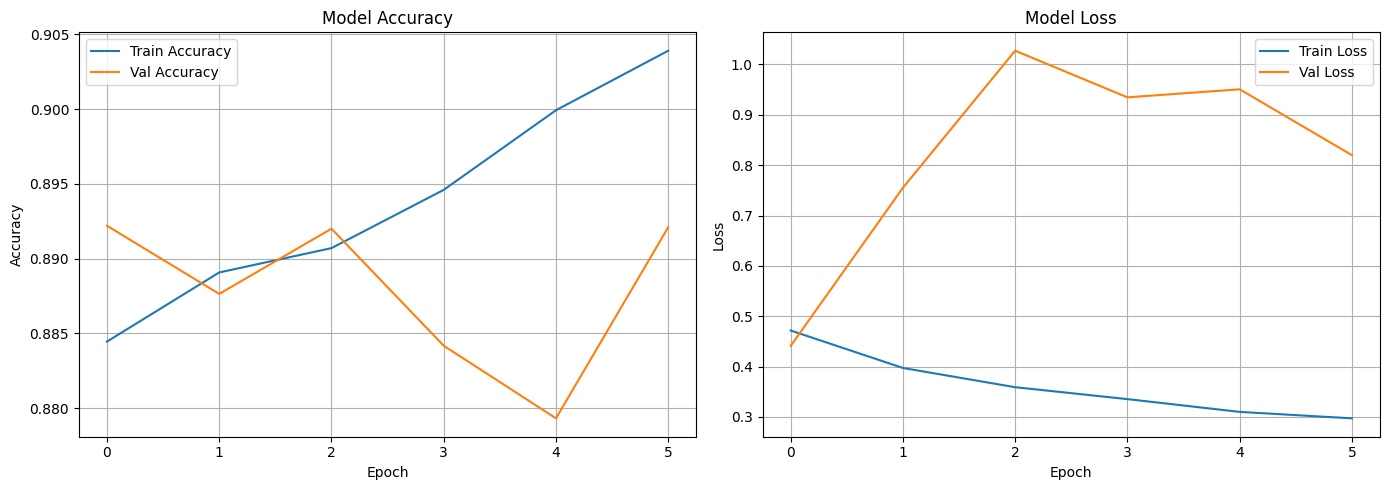


Final Training Accuracy: 0.9039
Final Validation Accuracy: 0.8921


In [18]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy')
ax1.legend()
ax1.grid(True)

# Loss plot
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Val Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Model Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()

# Print final results
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f"\nFinal Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")

## Step 9: Evaluate on Test Set

In [19]:
# Evaluate on test set
print("Evaluating on test set...")
test_loss, test_accuracy = model.evaluate(ds_test_processed, verbose=1)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Evaluating on test set...
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7033 - loss: 0.8083

Test Accuracy: 0.7033
Test Loss: 0.8083


## Step 10: Export TensorFlow Lite Models

We'll export both:
1. **Float32 model** - Full precision model
2. **INT8 quantized model** - Required for Edge TPU deployment

In [20]:
import os

# Create models directory
os.makedirs('trained_models', exist_ok=True)

# 1. Convert to Float32 TFLite model
print("Converting to Float32 TFLite model...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save float model
float_model_path = 'trained_models/model.tflite'
with open(float_model_path, 'wb') as f:
    f.write(tflite_model)
    
float_size = os.path.getsize(float_model_path) / 1024  # KB
print(f"Float32 model saved: {float_model_path}")
print(f"Float32 model size: {float_size:.2f} KB")

Converting to Float32 TFLite model...
INFO:tensorflow:Assets written to: /tmp/tmp_hel9rur/assets


INFO:tensorflow:Assets written to: /tmp/tmp_hel9rur/assets


Saved artifact at '/tmp/tmp_hel9rur'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 16000), dtype=tf.float32, name='keras_tensor_16')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  137712295871504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137712295876112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137712295876496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137712295877456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137712295877264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137712295876688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137712295877072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137712295876304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137712295875728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137712295878608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137712295878416: 

W0000 00:00:1762525727.260885   57077 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1762525727.260916   57077 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-11-07 14:28:47.261091: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp_hel9rur
2025-11-07 14:28:47.262390: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-11-07 14:28:47.262398: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp_hel9rur
2025-11-07 14:28:47.274129: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-11-07 14:28:47.338954: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp_hel9rur
2025-11-07 14:28:47.358851: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 97762 microseconds.


Float32 model saved: trained_models/model.tflite
Float32 model size: 241.30 KB


In [21]:
# 2. Convert to INT8 quantized TFLite model (Edge TPU compatible)
print("\nConverting to INT8 quantized TFLite model...")

# Representative dataset for quantization
def representative_dataset():
    for spectrograms, _ in ds_train_processed.take(100):
        # Yield spectrograms for calibration
        for i in range(min(len(spectrograms), 1)):  # Use one example per batch
            yield [tf.expand_dims(spectrograms[i], 0)]

# Configure converter for full integer quantization (Edge TPU requirement)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset

# Full integer quantization for Edge TPU
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Convert
print("Quantizing model (this may take a few minutes)...")
tflite_quant_model = converter.convert()

# Save quantized model
quant_model_path = 'trained_models/model_int8.tflite'
with open(quant_model_path, 'wb') as f:
    f.write(tflite_quant_model)
    
quant_size = os.path.getsize(quant_model_path) / 1024  # KB
print(f"\n✓ INT8 model saved: {quant_model_path}")
print(f"✓ INT8 model size: {quant_size:.2f} KB")

# Compare sizes
compression_ratio = (1 - quant_size / float_size) * 100
print(f"\nCompression: {compression_ratio:.1f}% size reduction")
print(f"\nThis INT8 model is ready for Edge TPU compilation.")


Converting to INT8 quantized TFLite model...
INFO:tensorflow:Assets written to: /tmp/tmpi76w0_ki/assets


INFO:tensorflow:Assets written to: /tmp/tmpi76w0_ki/assets


Saved artifact at '/tmp/tmpi76w0_ki'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 16000), dtype=tf.float32, name='keras_tensor_16')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  137712295871504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137712295876112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137712295876496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137712295877456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137712295877264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137712295876688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137712295877072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137712295876304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137712295875728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137712295878608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137712295878416: 

/home/suranjan/miniconda3/envs/coral/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1762526069.072627   57077 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1762526069.072659   57077 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-11-07 14:34:29.072855: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpi76w0_ki
2025-11-07 14:34:29.074148: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-11-07 14:34:29.074157: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpi76w0_ki
2025-11-07 14:34:29.086878: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-11-07 14:34:29.156938: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at p

INT8 model saved: trained_models/model_int8.tflite
INT8 model size: 79.20 KB

Size reduction: 67.18%

INT8 quantization is required for Edge TPU deployment.


2025-11-07 14:35:51.488193: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8
2025-11-07 14:35:51.516877: W tensorflow/compiler/mlir/lite/flatbuffer_export.cc:3705] Skipping runtime version metadata in the model. This will be generated by the exporter.


## Step 11: Compile for Edge TPU

To compile the INT8 model for Edge TPU deployment on Coral Dev Board Micro:

### Install Edge TPU Compiler

```bash
# Add Coral repository
curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | \
  sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

# Install compiler
sudo apt-get update
sudo apt-get install edgetpu-compiler
```

### Compile Model

```bash
# Compile for Edge TPU
edgetpu_compiler trained_models/model_int8.tflite
```

This produces `model_int8_edgetpu.tflite` optimized for Coral Edge TPU.

### Deploy to Coral Dev Board Micro

Copy the compiled model to your Coral project:

```bash
# Copy to examples directory (modify path as needed)
cp trained_models/model_int8_edgetpu.tflite \
   /path/to/coralmicro/examples/classify_speech/
```

Then rebuild and flash your application:

```bash
bash build.sh
python3 scripts/flashtool.py --build_dir build --elf_path \
  build/examples/classify_speech/classify_speech
```

## Checkpoint Questions (from Tutorial)

1. **What final accuracy did your model achieve?**
   - Check the test accuracy above

2. **Compare file sizes of float vs INT8 TFLite models.**
   - See the size comparison above

3. **Why is INT8 quantization required for Coral Edge TPU?**
   - Edge TPU is optimized for INT8 operations, providing faster inference with lower power consumption
   - INT8 models are much smaller, fitting better in limited memory
   - The hardware accelerator only supports quantized operations

4. **How do the left, right, and go commands map to robot motion?**
   - left (0): Turn robot left
   - right (1): Turn robot right  
   - go (2): Move robot forward

## Summary

You have successfully:
- ✅ Downloaded the Speech Commands dataset
- ✅ Configured for three keywords (left, right, go)
- ✅ Built and trained a CNN keyword spotting model
- ✅ Exported both Float32 and INT8 TFLite models
- ✅ Documented training results

**Next Steps:**
1. Compile the INT8 model for Edge TPU
2. Deploy to Coral Dev Board Micro
3. Integrate with MATLAB simulation (Task 3)
4. Conduct Hardware-in-the-Loop testing (Task 4)